# Experiments with Python code in Doc2Vec

In [1]:
import multiprocessing
from pathlib import Path
import ast
import astor
import tokenize
import io

import gensim.models.doc2vec
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"


In [2]:
test_code_dir = Path('test_data')
train_code_dir = Path('training_data')
models_dir = Path('models')

In [3]:
def split_methods(code):
    """Parse Python files into separate methods

        :param code: Python code to parse.
        :rtype: map
    """
    funcs = []
    try:
        tree = ast.parse(code)
        for node in ast.walk(tree):
            if isinstance(node, ast.FunctionDef):
                func = astor.to_source(node)
                funcs.append(func)
    except:
        pass

    if not funcs:
        funcs = code  # just send everything back
    return funcs

In [4]:
def read_train_corpus():
    count = 0
    for i, file in enumerate(train_code_dir.glob('./python_projects/**/*.py')):
        if not file.is_file():  # oddly, some of these are not files
            continue
        with file.open() as f:
            try:
                code = f.read()
                methods = split_methods(code)
                for method in methods:
                    tokens = list(tokenize.generate_tokens(io.StringIO(method).readline))
                    tokens = [token for t in tokens if t.type == tokenize.NAME or t.type == tokenize.OP for token in t.string.split(" ")]
                    if tokens:
                        tag = "Method_%s" % count
                        count += 1
                        yield TaggedDocument(tokens, [tag])
                        
            except tokenize.TokenError as te:
                # print("%s: %s" % (type(te).__name__, te.args))
                pass
            except UnicodeDecodeError as e:
                # print("%s: %s" % (type(e).__name__, e))
                pass
            except Exception as e:
                print("%s: %s" % (type(e).__name__, e))
                pass
     
        if i % 10000 == 0:
            print("Processed %s records" % i)
        if i > 25000:
            break


%time train_corpus = list(read_train_corpus())
print("Training corpus size: %s" % len(train_corpus))


Processed 0 records


Processed 10000 records


Processed 20000 records


CPU times: user 5min 37s, sys: 7.65 s, total: 5min 44s
Wall time: 5min 55s
Training corpus size: 1328624


In [5]:
# doc2vec parameters
vector_size = 100
window_size = 8
min_count = 5
sampling_threshold = 1e-5
negative_size = 5
epochs = 20
dm = 0  # 0 = dbow; 1 = dmpv
worker_count = multiprocessing.cpu_count()  # number of parallel processes

In [6]:
%%time
model = Doc2Vec(train_corpus,
                vector_size=vector_size,
                window=window_size,
                min_count=min_count,
                sample=sampling_threshold,
                negative=negative_size,
                dbow_words=1,
                epochs=epochs,
                dm=dm,
                workers=worker_count)


CPU times: user 36min 27s, sys: 16min 41s, total: 53min 9s
Wall time: 31min 54s


In [7]:
model.save(str(models_dir / "github-python-vectors.bin"))

In [8]:
model.wv.most_similar('i')

[('range', 0.8016794323921204),
 ('enumerate', 0.7861272096633911),
 ('for', 0.7633408904075623),
 ('j', 0.7592484354972839),
 ('len', 0.7350738048553467),
 ('append', 0.7257459163665771),
 ('in', 0.7195432186126709),
 ('xrange', 0.6995493173599243),
 ('-', 0.6876413822174072),
 ('+=', 0.6360097527503967)]

In [9]:
model.wv.most_similar('count')

[('quick', 0.5708381533622742),
 ('sporadic', 0.550082802772522),
 ('old_history_docs', 0.5490986704826355),
 ('count2', 0.5381618738174438),
 ('main_groups', 0.5371947884559631),
 ('size_g', 0.526528537273407),
 ('snap_rows', 0.5264338254928589),
 ('action_past', 0.520855724811554),
 ('action_present', 0.5192648768424988),
 ('migrate_instance_groups_to_api_db', 0.5191962122917175)]

In [10]:
def read_test_corpus():
    color_val = 0
    for programming_language in test_code_dir.glob('./Python'):
        if not programming_language.is_dir():
            continue
        for programming_task in programming_language.glob('./*'):
            if not programming_task.is_dir():
                continue
            color_val += 1
            for implementation in programming_task.glob('./*'):
                with implementation.open() as f:
                    try:
                        code = f.read()
                        tokens = list(tokenize.generate_tokens(io.StringIO(code).readline))
                        tokens = [token for t in tokens if t.type == tokenize.NAME or t.type == tokenize.OP for token in t.string.split(" ")]
                        if tokens:
                            # print("Task: %s; Color: %s" % (programming_task.name, color_val))
                            yield TaggedDocument(tokens, [programming_task.name, implementation.name, programming_language.name, color_val])
                    except tokenize.TokenError as e:
                        # print("%s: %s" % (type(e).__name__, e))
                        pass
                    except IndentationError as e:
                        # print("%s: %s" % (type(e).__name__, e))
                        pass
                    except Exception as e:
                        print("%s: %s" % (type(e).__name__, e))
                        pass

              
test_corpus = list(read_test_corpus())
print("Test corpus size: %s" % len(test_corpus))

Test corpus size: 659


In [11]:
docs = [{'name': doc.tags[0], 'vec': model.infer_vector(doc.words, steps=50), 'color': doc.tags[3]} for doc in test_corpus]
num_colors = docs[-1]['color']

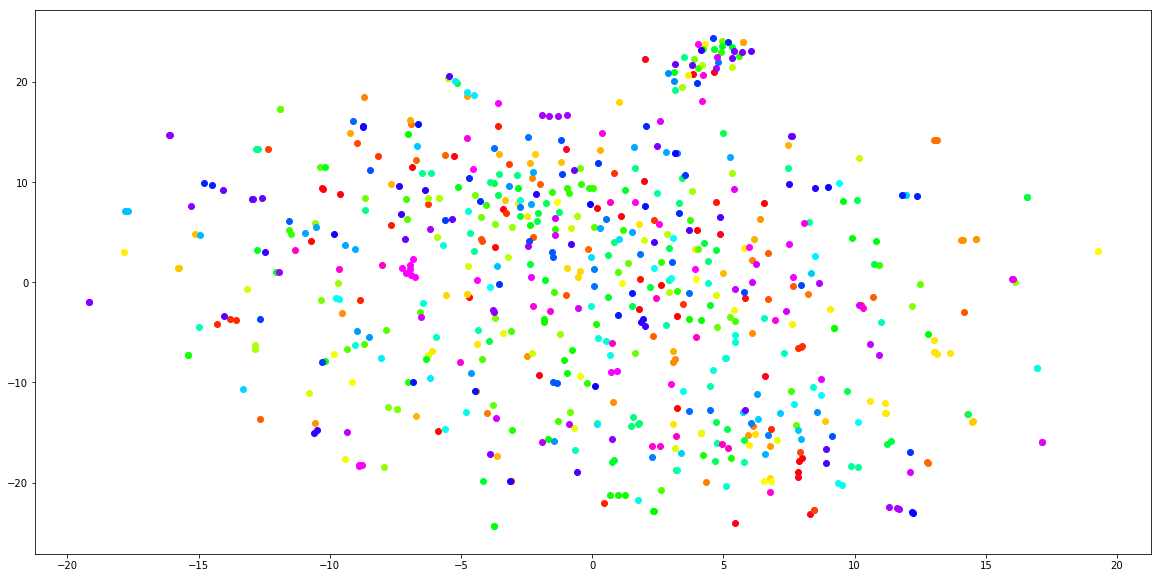

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import matplotlib
from sklearn.manifold import TSNE

matplotlib.rcParams['figure.figsize'] = (20, 10)

tsne = TSNE(n_components=2)
twoDimVecs = tsne.fit_transform([doc['vec'] for doc in docs])

cm = plt.get_cmap('gist_rainbow')
cNorm = colors.Normalize(vmin=0, vmax=num_colors-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

fig, ax = plt.subplots()
for doc, twoDimVec in zip(docs, twoDimVecs):
    ax.scatter(twoDimVec[0], twoDimVec[1], color=scalarMap.to_rgba(doc['color']))
plt.show()